In [18]:
import os
import numpy as np
from PIL import Image
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns

def collect_grayscale_distributions(root_dirs):
    distributions = defaultdict(list)
    
    for root_dir in root_dirs:
        index_label_dir = os.path.join(root_dir, 'indexLabel')
        
        if not os.path.exists(index_label_dir):
            print(f"Warning: {index_label_dir} does not exist.")
            continue
        
        for filename in os.listdir(index_label_dir):
            if filename.endswith('.png'):
                file_path = os.path.join(index_label_dir, filename)
                try:
                    img = Image.open(file_path).convert('L')
                    img_np = np.array(img)
                    
                    # Exclude grayscale values such as 0, 1, and 17
                    mask = np.isin(img_np, [0, 1, 17], invert=True)
                    valid_pixels = img_np[mask]
                    
                    if valid_pixels.size > 0:
                        unique, counts = np.unique(valid_pixels, return_counts=True)
                        total_valid_pixels = valid_pixels.size
                        
                        # Calculate the proportion for each grayscale value
                        for gray_value, count in zip(unique, counts):
                            distributions[gray_value].append(count / total_valid_pixels)
                    else:
                        print(f"Warning: No valid pixels in {file_path}")
                        
                except Exception as e:
                    print(f"Error processing {file_path}: {str(e)}")
    
    return distributions

def visualize_grayscale_distribution(distributions, save_path):
    # Calculate the average proportion of each grayscale value
    avg_proportions = {k: np.mean(v) for k, v in distributions.items()}
    
    # Sort for better presentation
    sorted_items = sorted(avg_proportions.items(), key=lambda x: x[1], reverse=True)
    gray_values, proportions = zip(*sorted_items)

    plt.figure(figsize=(15, 8))
    sns.barplot(x=list(gray_values), y=list(proportions))
    plt.title('Average Grayscale Value Distribution')
    plt.xlabel('Grayscale Value')
    plt.ylabel('Average Proportion')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(save_path)
    plt.close()

if __name__ == "__main__":
    root_dirs = [
        os.path.join('..', 'data', 'WildScenes', 'WildScenes2d', 'V-01'),
        os.path.join('..', 'data', 'WildScenes', 'WildScenes2d', 'V-02'),
        os.path.join('..', 'data', 'WildScenes', 'WildScenes2d', 'V-03')
    ]

    grayscale_distributions = collect_grayscale_distributions(root_dirs)

    # Print statistical information for each grayscale value
    for gray_value, proportions in grayscale_distributions.items():
        print(f"Gray value {gray_value}:")
        print(f"  Number of images: {len(proportions)}")
        print(f"  Average proportion: {np.mean(proportions):.4f}")
        print(f"  Min proportion: {np.min(proportions):.4f}")
        print(f"  Max proportion: {np.max(proportions):.4f}")
        print()

    # Visualize the distribution of grayscale values
    save_dir=os.path.join("visualization_results","dataset_review")
    os.makedirs(save_dir, exist_ok=True)
    save_path = os.path.join(save_dir, 'grayscale_distribution.png')
    visualize_grayscale_distribution(grayscale_distributions, save_path)
    print(f"Visualization saved to {save_path}")

Gray value 2:
  Number of images: 2824
  Average proportion: 0.1361
  Min proportion: 0.0000
  Max proportion: 0.7083

Gray value 7:
  Number of images: 3047
  Average proportion: 0.1368
  Min proportion: 0.0013
  Max proportion: 0.5324

Gray value 8:
  Number of images: 3056
  Average proportion: 0.5345
  Min proportion: 0.0893
  Max proportion: 0.9534

Gray value 9:
  Number of images: 961
  Average proportion: 0.0770
  Min proportion: 0.0000
  Max proportion: 0.5249

Gray value 15:
  Number of images: 1757
  Average proportion: 0.0114
  Min proportion: 0.0000
  Max proportion: 0.1909

Gray value 16:
  Number of images: 855
  Average proportion: 0.0042
  Min proportion: 0.0000
  Max proportion: 0.1843

Gray value 18:
  Number of images: 2971
  Average proportion: 0.1672
  Min proportion: 0.0000
  Max proportion: 0.6761

Gray value 11:
  Number of images: 24
  Average proportion: 0.0040
  Min proportion: 0.0000
  Max proportion: 0.0206

Gray value 14:
  Number of images: 241
  Average

In [19]:
import os
import numpy as np
from PIL import Image, ImageEnhance
from collections import defaultdict
from sklearn.model_selection import train_test_split
import pandas as pd
import random

def collect_grayscale_distributions(root_dirs):
    distributions = defaultdict(list)
    image_distributions = {}
    
    for root_dir in root_dirs:
        index_label_dir = os.path.join(root_dir, 'indexLabel')
        image_dir = os.path.join(root_dir, 'image')
        
        if not os.path.exists(index_label_dir) or not os.path.exists(image_dir):
            continue
        
        for filename in os.listdir(index_label_dir):
            if filename.endswith('.png'):
                label_path = os.path.join(index_label_dir, filename)
                image_path = os.path.join(image_dir, filename)
                
                if not os.path.exists(image_path):
                    continue
                
                try:
                    img = Image.open(label_path).convert('L')
                    img_np = np.array(img)
                    
                    mask = np.isin(img_np, [0, 1, 17], invert=True)
                    valid_pixels = img_np[mask]
                    
                    if valid_pixels.size > 0:
                        unique, counts = np.unique(valid_pixels, return_counts=True)
                        total_valid_pixels = valid_pixels.size
                        
                        img_distribution = {}
                        for gray_value, count in zip(unique, counts):
                            proportion = count / total_valid_pixels
                            distributions[gray_value].append(proportion)
                            img_distribution[gray_value] = proportion
                        
                        image_distributions[image_path] = (img_distribution, label_path)
                except Exception:
                    pass
    
    return distributions, image_distributions

def get_main_classes(image_distributions, min_threshold=0.05, max_threshold=0.2):
    main_classes = {}
    class_counts = defaultdict(int)
    total_images = len(image_distributions)
    
    for _, (dist, _) in image_distributions.items():
        for cls in dist.keys():
            class_counts[cls] += 1
    
    rare_classes = {cls for cls, count in class_counts.items() if count < total_images * 0.05}
    
    for image_path, (dist, _) in image_distributions.items():
        significant_classes = [cls for cls, prop in dist.items() if (cls in rare_classes and prop >= min_threshold) or prop >= max_threshold]
        if not significant_classes:
            significant_classes = [max(dist, key=dist.get)]
        main_classes[image_path] = tuple(significant_classes)
    
    return main_classes

def augment_image(image_path, label_path):
    image = Image.open(image_path)
    label = Image.open(label_path)
    augmented_image = image.transpose(Image.FLIP_LEFT_RIGHT)
    augmented_label = label.transpose(Image.FLIP_LEFT_RIGHT)
    enhancer = ImageEnhance.Brightness(augmented_image)
    augmented_image = enhancer.enhance(1.2)
    return augmented_image, augmented_label

def augment_rare_classes(image_distributions, main_classes, threshold=10):
    augmented_data = {}
    class_counts = defaultdict(int)
    
    for img, classes in main_classes.items():
        for cls in classes:
            class_counts[cls] += 1
    
    for cls, count in class_counts.items():
        if count < threshold:
            for img in [img for img, classes in main_classes.items() if cls in classes]:
                aug_image, aug_label = augment_image(img, image_distributions[img][1])
                aug_image_path = img.replace('.png', '_aug.png')
                aug_label_path = image_distributions[img][1].replace('.png', '_aug.png')
                aug_image.save(aug_image_path)
                aug_label.save(aug_label_path)
                augmented_data[aug_image_path] = (image_distributions[img][0], aug_label_path)
    
    image_distributions.update(augmented_data)
    return image_distributions

def stratified_split(image_distributions, train_ratio=0.7, valid_ratio=0.2):
    main_classes = get_main_classes(image_distributions)
    all_classes = set(cls for classes in main_classes.values() for cls in classes)
    
    train_set, valid_set, test_set = [], [], []
    class_to_images = defaultdict(list)
    
    for img, classes in main_classes.items():
        for cls in classes:
            class_to_images[cls].append(img)
    
    for cls in all_classes:
        cls_images = class_to_images[cls]
        random.shuffle(cls_images)
        
        n_train = max(int(len(cls_images) * train_ratio), 1)
        n_valid = max(int(len(cls_images) * valid_ratio), 1)
        
        train_set.extend((img, image_distributions[img][1]) for img in cls_images[:n_train])
        valid_set.extend((img, image_distributions[img][1]) for img in cls_images[n_train:n_train+n_valid])
        test_set.extend((img, image_distributions[img][1]) for img in cls_images[n_train+n_valid:])
    
    return list(set(train_set)), list(set(valid_set)), list(set(test_set))

def save_split_results(train_set, valid_set, test_set, csv_files):
    os.makedirs(os.path.dirname(csv_files['train']), exist_ok=True)
    
    pd.DataFrame(train_set, columns=['image', 'label']).to_csv(csv_files['train'], index=False)
    pd.DataFrame(valid_set, columns=['image', 'label']).to_csv(csv_files['valid'], index=False)
    pd.DataFrame(test_set, columns=['image', 'label']).to_csv(csv_files['test'], index=False)

if __name__ == "__main__":
    root_dirs = [
        os.path.join('..', 'data', 'WildScenes', 'WildScenes2d', 'V-01'),
        os.path.join('..', 'data', 'WildScenes', 'WildScenes2d', 'V-02'),
        os.path.join('..', 'data', 'WildScenes', 'WildScenes2d', 'V-03')
    ]

    _, image_distributions = collect_grayscale_distributions(root_dirs)
    image_distributions = augment_rare_classes(image_distributions, get_main_classes(image_distributions))
    train_set, valid_set, test_set = stratified_split(image_distributions)

    _data_list_dir = os.path.join('datasets', 'data_list')
    _csv_files = {
        'train': os.path.join(_data_list_dir, 'train.csv'),
        'valid': os.path.join(_data_list_dir, 'valid.csv'),
        'test': os.path.join(_data_list_dir, 'test.csv'),
    }

    save_split_results(train_set, valid_set, test_set, _csv_files)

Loaded cached results from class_image_cache.json
Class 0: 2594 images
Class 5: 2790 images
Class 6: 2799 images
Class 7: 846 images
Class 12: 1598 images
Class 13: 818 images
Class 16: 2675 images
Class 14: 2717 images
Class 11: 232 images
Class 9: 283 images
Class 3: 96 images
Class 2: 194 images
Class 1: 67 images
Class 8: 44 images
Class 4: 2 images
Class 10: 6 images
Loaded cached results from class_image_cache.json

Class 4 images:
../data/WildScenes/WildScenes2d/V-02/image/1623370474-625888651.png
../data/WildScenes/WildScenes2d/V-02/image/1623370640-449779203.png

Class 14 images:
../data/WildScenes/WildScenes2d/V-01/image/1623377790-818434554.png
../data/WildScenes/WildScenes2d/V-01/image/1623377792-158486120.png
../data/WildScenes/WildScenes2d/V-01/image/1623377796-111739618.png
../data/WildScenes/WildScenes2d/V-01/image/1623377799-999188899.png
../data/WildScenes/WildScenes2d/V-01/image/1623377800-668195159.png
../data/WildScenes/WildScenes2d/V-01/image/1623377804-620552356.

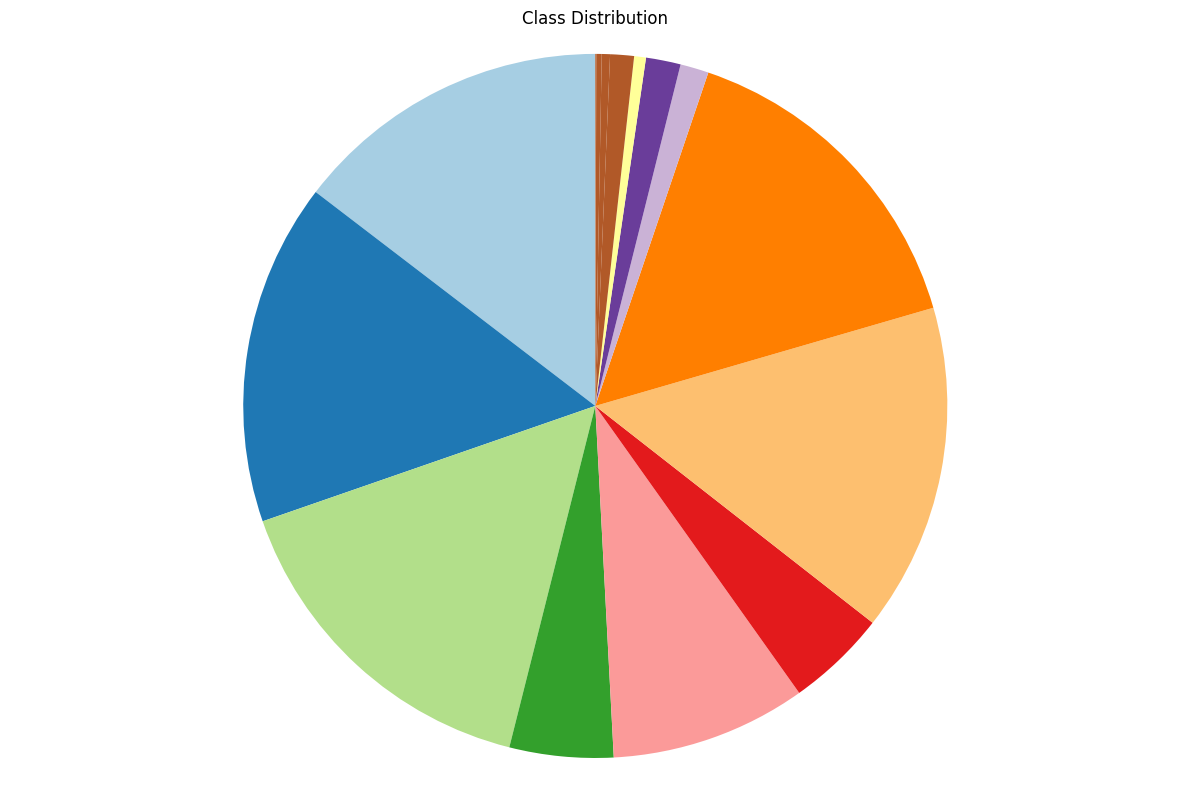

In [12]:
import os
import numpy as np
from PIL import Image
from tqdm import tqdm
import json
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns

def find_images_with_classes(root_dirs, label_to_trainid, target_classes=None, cache_file='class_image_cache.json'):
    if os.path.exists(cache_file):
        with open(cache_file, 'r') as f:
            class_to_images = json.load(f)
        print(f"Loaded cached results from {cache_file}")
    else:
        class_to_images = defaultdict(list)
        for root_dir in root_dirs:
            index_label_dir = os.path.join(root_dir, 'indexLabel')
            image_dir = os.path.join(root_dir, 'image')
            if not os.path.exists(index_label_dir) or not os.path.exists(image_dir):
                print(f"Warning: {index_label_dir} or {image_dir} does not exist.")
                continue
            for filename in tqdm(os.listdir(index_label_dir), desc=f"Scanning images in {root_dir}"):
                if filename.endswith('.png'):
                    label_path = os.path.join(index_label_dir, filename)
                    image_path = os.path.join(image_dir, filename)
                    if not os.path.exists(image_path):
                        print(f"Warning: Image file not found for {filename}")
                        continue
                    label = np.array(Image.open(label_path))
                    unique_classes = np.unique(label)
                    for cls in unique_classes:
                        if cls in label_to_trainid:
                            train_id = label_to_trainid[cls]
                            class_to_images[str(train_id)].append(image_path)
        with open(cache_file, 'w') as f:
            json.dump(class_to_images, f)
        print(f"Saved results to {cache_file}")
    
    if target_classes:
        return {cls: class_to_images[str(cls)] for cls in target_classes if str(cls) in class_to_images}
    return {int(k): v for k, v in class_to_images.items()}

def visualize_class_distribution(class_images, save_dir):
    os.makedirs(save_dir, exist_ok=True)
    classes = list(class_images.keys())
    image_counts = [len(images) for images in class_images.values()]

    # Bar chart
    plt.figure(figsize=(15, 8))
    sns.barplot(x=classes, y=image_counts)
    plt.title('Number of Images per Class')
    plt.xlabel('Class')
    plt.ylabel('Number of Images')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, 'class_distribution_bar.png'))
    plt.close()

    # Pie chart
    plt.figure(figsize=(12, 8))
    wedges, _ = plt.pie(image_counts, startangle=90, colors=plt.cm.Paired(np.arange(len(classes))))
    plt.title('Class Distribution')
    plt.axis('equal')
    plt.tight_layout()
    
    # Pie chart displays category distribution, legend displays detailed information
    plt.figure(figsize=(12, 8))
    plt.pie(image_counts, startangle=90, colors=[w.get_facecolor() for w in wedges], labels=['']*len(classes))
    plt.title('Class Distribution')
    plt.axis('equal')

    # Add legend
    plt.legend(handles=wedges, labels=classes, title='Classes', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, 'class_distribution_pie_with_legend.png'))
    plt.close()

def visualize_class_distribution_heatmap(class_images, save_dir):
    os.makedirs(save_dir, exist_ok=True)
    classes = list(class_images.keys())
    image_counts = [len(images) for images in class_images.values()]

    plt.figure(figsize=(10, 8))
    sns.heatmap(np.array(image_counts).reshape(-1, 1), annot=True, fmt='d', cmap='YlOrRd', xticklabels=['Number of Images'], yticklabels=classes)
    plt.title('Class Distribution Heatmap')
    plt.xlabel('Count')
    plt.ylabel('Class')
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, 'class_distribution_heatmap.png'))
    plt.close()

if __name__ == "__main__":
    save_dir = os.path.join("visualization_results", "dataset_review")
    root_dirs = [
        os.path.join('..', 'data', 'WildScenes', 'WildScenes2d', 'V-01'),
        os.path.join('..', 'data', 'WildScenes', 'WildScenes2d', 'V-02'),
        os.path.join('..', 'data', 'WildScenes', 'WildScenes2d', 'V-03')
    ]
    
    label_to_trainid = {
        0: 15, 1: 16, 2: 0, 3: 1, 4: 2, 5: 3, 6: 4, 7: 5, 8: 6, 9: 7,
        10: 8, 11: 16, 12: 9, 13: 10, 14: 11, 15: 12, 16: 13, 17: 16, 18: 14
    }
    
    all_class_images = find_images_with_classes(root_dirs, label_to_trainid)
    
    visualize_class_distribution(all_class_images, save_dir)
    
    visualize_class_distribution_heatmap(all_class_images, save_dir)

    for cls, images in all_class_images.items():
        print(f"Class {cls}: {len(images)} images")
    
    rare_classes = [4, 14]  
    rare_class_images = find_images_with_classes(root_dirs, label_to_trainid, target_classes=rare_classes)
    
    for cls, images in rare_class_images.items():
        print(f"\nClass {cls} images:")
        for img in images[:10]:  
            print(img)
        if len(images) > 10:
            print(f"... and {len(images) - 10} more")

    for cls, images in all_class_images.items():
        print(f"  Class {cls}: {len(images)} images")


In [21]:
import os
import pandas as pd

# Define file path
base_dir = 'visualization_results'
save_dir = os.path.join(base_dir, 'dataset_review')
os.makedirs(save_dir, exist_ok=True)  # Ensure that the save directory exists

model_dirs = [
    'DeepLabV3_Resnet101',
    'FCN_ResNet50',
    'Mask2Former',
    'Unet'
]
file_name = 'iou_results.txt'

file_paths = [os.path.join(base_dir, model_dir, file_name) for model_dir in model_dirs]
model_names = ["DeepLabV3 Resnet101", "FCN ResNet50", "Mask2Former", "Unet"]
mean_ious = []
class_iou_dict = {}

# Read file data
for file_path, model_name in zip(file_paths, model_names):
    with open(file_path, 'r') as file:
        lines = file.readlines()
        mean_iou = float(lines[0].split(': ')[1].strip())
        mean_ious.append(mean_iou)
        
        for line in lines[2:]:
            if ': ' in line:
                parts = line.split(': ')
                if len(parts) == 2:
                    class_name = parts[0].split(' ')[1]
                    iou = float(parts[1].strip())
                    if class_name not in class_iou_dict:
                        class_iou_dict[class_name] = []
                    class_iou_dict[class_name].append(iou)
                else:
                    print(f"Warning: Unexpected format in line '{line.strip()}'")
            else:
                print(f"Warning: No delimiter ':' found in line '{line.strip()}'")

# Create Mean IoU DataFrame
mean_iou_df = pd.DataFrame({
    'Model': model_names,
    'Mean IoU': mean_ious
})

# Create Class IoU DataFrame
iou_data = {class_name: [class_iou_dict[class_name][i] if i < len(class_iou_dict[class_name]) else None for i in range(len(model_names))] for class_name in class_iou_dict}
class_iou_df = pd.DataFrame(iou_data, index=model_names)

# generate LaTeX table
mean_iou_latex = mean_iou_df.to_latex(float_format="%.2f", caption="Mean IoU Comparison Table", label="tab:mean_iou_comparison")
with open(os.path.join(save_dir, 'mean_iou_comparison_table.tex'), 'w') as f:
    f.write(mean_iou_latex)

class_iou_latex = class_iou_df.to_latex(float_format="%.2f", caption="Class IoU Comparison Table", label="tab:class_iou_comparison")
with open(os.path.join(save_dir, 'class_iou_comparison_table.tex'), 'w') as f:
    f.write(class_iou_latex)


In [22]:
import os
import pandas as pd

# Define file path
base_dir = 'visualization_results'
save_dir = os.path.join(base_dir, 'dataset_review')
os.makedirs(save_dir, exist_ok=True)  # Ensure that the save directory exists

model_dirs = [
    'DeepLabV3_Resnet101',
    'FCN_ResNet50',
    'Mask2Former',
    'Unet'
]
file_name = 'iou_results.txt'

file_paths = [os.path.join(base_dir, model_dir, file_name) for model_dir in model_dirs]
model_names = ["DeepLabV3 Resnet101", "FCN ResNet50", "Mask2Former", "Unet"]
class_names = []
iou_data = []

# read the file data
for file_path, model_name in zip(file_paths, model_names):
    with open(file_path, 'r') as file:
        lines = file.readlines()
        # skip the Mean IoU of first line
        model_iou = []
        for line in lines[2:]:
            if ': ' in line:
                parts = line.split(': ')
                if len(parts) == 2:
                    class_name = parts[0].split(' ')[1]
                    iou = float(parts[1].strip())
                    if class_name not in class_names:
                        class_names.append(class_name)
                    model_iou.append(iou)
                else:
                    print(f"Warning: Unexpected format in line '{line.strip()}'")
            else:
                print(f"Warning: No delimiter ':' found in line '{line.strip()}'")
        iou_data.append(model_iou)

# Create DataFrame
iou_df = pd.DataFrame(iou_data, index=model_names, columns=class_names)

# print the table
print(iou_df)

# Generate LaTeX table
latex_table = iou_df.to_latex(float_format="%.2f", caption="IoU Comparison Table", label="tab:iou_comparison")
with open(os.path.join(save_dir, 'iou_comparison_table.tex'), 'w') as f:
    f.write(latex_table)


                          0       1       2       3    4       5       6  \
DeepLabV3 Resnet101  0.7240  0.1602  0.6591  0.3196  0.0  0.3819  0.8131   
FCN ResNet50         0.7562  0.2913  0.6996  0.4130  0.0  0.3743  0.8169   
Mask2Former          0.6842  0.2164  0.5367  0.4369  0.0  0.3969  0.8298   
Unet                 0.7226  0.2163  0.6434  0.2503  0.0  0.5368  0.8481   

                          7       8       9   10      11      12      13  \
DeepLabV3 Resnet101  0.2737  0.0966  0.1611  0.0  0.3311  0.1825  0.1263   
FCN ResNet50         0.3637  0.3272  0.1900  0.0  0.4078  0.2388  0.1505   
Mask2Former          0.1235  0.0000  0.1498  0.0  0.3179  0.1073  0.1224   
Unet                 0.3122  0.0000  0.1170  0.0  0.3964  0.2512  0.2471   

                         14   15      16  
DeepLabV3 Resnet101  0.6510  0.0  0.4816  
FCN ResNet50         0.6916  0.0  0.4909  
Mask2Former          0.6335  0.0  0.6018  
Unet                 0.6921  0.0  0.5461  
